# About this Notebook

This is a Python notebook. This is the notebook you'll use to run and create the analysis code on pickle data sets. Pickle files are created and premanufactured from ROOT files from MicroBooNE LAr experiment.

You should have access to: example_neutrino.ipynb, neutrino_function.py, data folder. You are free to modify neutrino_function.py or create your own plotting functions.

**IMPORTANT:** It is strongly recommended that only **one** student of a lab pair should edit this notebook and the files contained within the server directories. This is because both students cannot see the same live edit of the notebook or files at the same time, and it is easy to accidently overwrite each other.

Code that is commented out with two hashtags should be uncommented when in use.

# All imports

The basic libraries, you may import more if there are present on the server's environment. If you dont have these packages installed on your local machine, you can use **pip install X** or **pip3 install X** to start using them.

In [1]:
import numpy as np
import uproot3
import pickle

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import Neutrino_functions

from math import *
from scipy.optimize import fmin

# MACHINE LEARNING IMPORTS
import sklearn
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Opening the MC and data frames

In [2]:
# MC
MC_file = './data/MC_EXT_flattened.pkl'

# Data
data_file = './data/data_flattened.pkl'

osc_data_file = './data/oscillated_data.pkl'

# Open file as pandas dataframe
MC_EXT = pd.read_pickle(MC_file)
data = pd.read_pickle(data_file)
osc_data = pd.read_pickle(osc_data_file)
# removing 'Subevent' from data
MC_EXT = MC_EXT.drop('Subevent', axis = 1)
data = data.drop('Subevent', axis = 1)

# You can display the dataframe by uncommenting these lines and running the cell

# Machine learning for Particle Classification

First, look at a sub-sample of our Monte Carlo data.

In [3]:
# Reduce the amount of data for visualisation purposes
MC_EXT_VIS = MC_EXT.sample(int(len(MC_EXT)/10))

# Resetting the index
MC_EXT_VIS.reset_index(drop=True, inplace=True)

# Removing high energy (unphysical) monte carlo results
MC_EXL_VIS = MC_EXT_VIS.drop(MC_EXT_VIS[MC_EXT_VIS.trk_energy_tot > 2].index, inplace = True)

# Resetting the index again
MC_EXT_VIS.reset_index(drop=True, inplace=True)

# Displaying dataframe
print("Length of new data sample: {}".format(len(MC_EXT_VIS)))
MC_EXT_VIS.head(10)


Length of new data sample: 14364


,_closestNuCosmicDist,trk_len_v,trk_distance_v,category,topological_score,trk_sce_end_z_v,trk_sce_end_y_v,trk_sce_end_x_v,trk_score_v,trk_llr_pid_score_v,...,reco_nu_vtx_sce_x,reco_nu_vtx_sce_y,reco_nu_vtx_sce_z,trk_energy_tot,trk_range_muon_mom_v,trk_mcs_muon_mom_v,weight,true_E,true_L,true_muon_mom
0,17.374125,22.41869,17.374125,21,0.378681,981.474976,-43.551983,60.315445,0.721959,-0.803951,...,46.580292,-9.886561,977.216309,0.498818,0.153654,0.17,0.200209,0.609994,471.893524,0.208512
1,137.303347,24.425678,46.726498,21,0.510437,148.743378,117.494781,44.829342,0.273968,0.466398,...,56.211136,60.698551,139.343445,0.894754,0.159541,0.136,0.158957,1.277511,453.152649,0.363422
2,99.223050,15.762223,90.140327,21,0.998874,644.574219,3.832879,133.6064,0.38027,0.603319,...,161.764954,7.686492,542.899658,1.336656,0.132755,0.109,0.158957,1.563097,454.942719,0.779566
3,62.606119,40.977859,0.825974,21,0.999051,657.682983,54.37162,120.122894,0.977762,0.915747,...,111.884827,74.583916,622.105957,1.496540,0.20395,0.293,0.158957,1.328202,435.462250,0.674010
4,63.479479,128.536194,2.635457,21,0.915830,128.738007,-34.263138,197.828186,0.999861,0.912223,...,100.630432,-4.840532,47.058483,0.451372,0.402517,0.390998,0.158957,0.980803,444.001099,0.417368
5,37.788474,187.93837,0.777564,21,0.380773,609.111084,-31.051418,94.860718,1.0,0.975367,...,186.488556,-103.891304,462.995605,0.624588,0.531792,0.498998,0.207069,0.636574,460.391968,0.510872
6,90.881465,8.581638,1.021883,21,0.930259,443.58551,-89.313255,247.70137,0.263446,0.098108,...,250.461304,-82.085587,445.287537,1.214382,0.104933,0.083,0.158957,1.566400,458.119232,0.398895
7,191.595263,62.93544,0.528274,21,0.300256,935.476318,-32.710361,58.188202,0.987967,0.899514,...,41.190704,12.847779,975.806213,0.613654,0.256624,0.281,0.158957,1.054369,427.994720,0.260947
8,200.246976,46.573643,0.353615,21,0.991685,265.430359,-46.938889,9.181934,0.941136,0.834167,...,36.708767,-81.306938,279.624359,1.234044,0.21779,0.154,0.158957,1.472543,434.387665,0.817828
9,285.726730,10.716012,2.180613,7,0.143419,599.957214,-109.525772,179.719208,0.014807,0.116224,...,176.586868,-106.903534,610.060852,0.840818,0.114086,0.077,0.257732,1.000000,0.000000,0.000000


# Exercise 5 Data Visualisation
Lets visualise some of the variables using *seaborn*

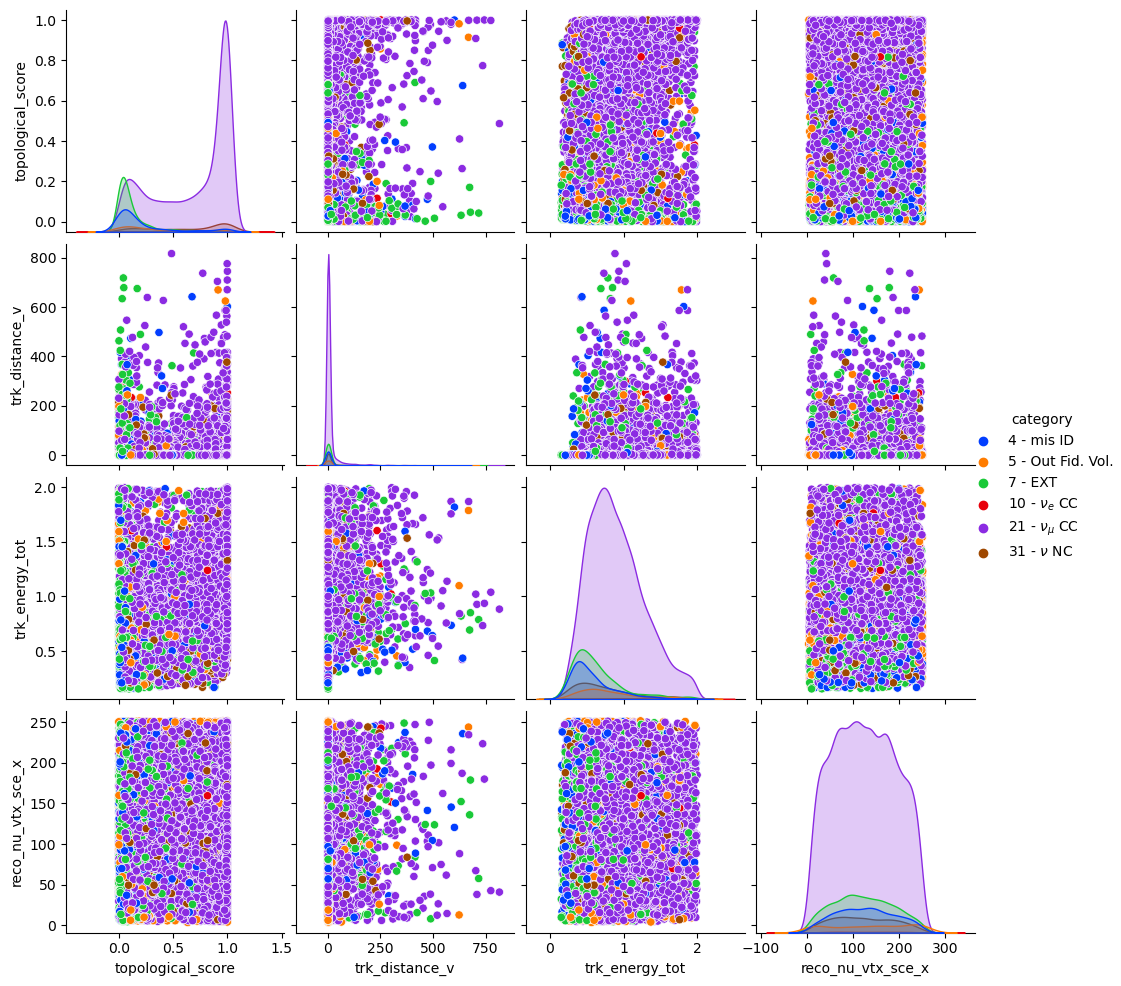

In [4]:
%matplotlib inline
# Visualising a couple of variables.
variable_list = ['category', 'topological_score', 'trk_distance_v', 'trk_energy_tot', 'reco_nu_vtx_sce_x']

# List of categories in text
ptype = [r"mis ID", r"Out Fid. Vol.", r"EXT", r"$\nu_e$ CC", r"$\nu_{\mu}$ CC", r"$\nu$ NC"]

# Plot data
fig = sns.pairplot(MC_EXT_VIS[variable_list], hue = 'category', palette = 'bright')

# Change location of legend
fig._legend.set_bbox_to_anchor((1.05, 0.5))

# Add Category number and type to legend
for t, l in zip(fig._legend.texts, ptype):
   t.set_text(str(t.get_text()) + " - " + str(l))

In [5]:
# Create a deep copy of MC_EXT_VIS without signal events
MC_EXT_NO_SIG = MC_EXT_VIS
MC_EXT_NO_SIG.head(5)
MC_EXT_NO_SIG.drop(MC_EXT_NO_SIG[MC_EXT_NO_SIG.category == 21].index, inplace = True)
MC_EXT_NO_SIG.head(5)
# Resetting the index again
MC_EXT_NO_SIG.reset_index(drop=True, inplace=True)

# Displaying dataframe
print("Length of new data sample: {}".format(len(MC_EXT_NO_SIG)))

Length of new data sample: 3955


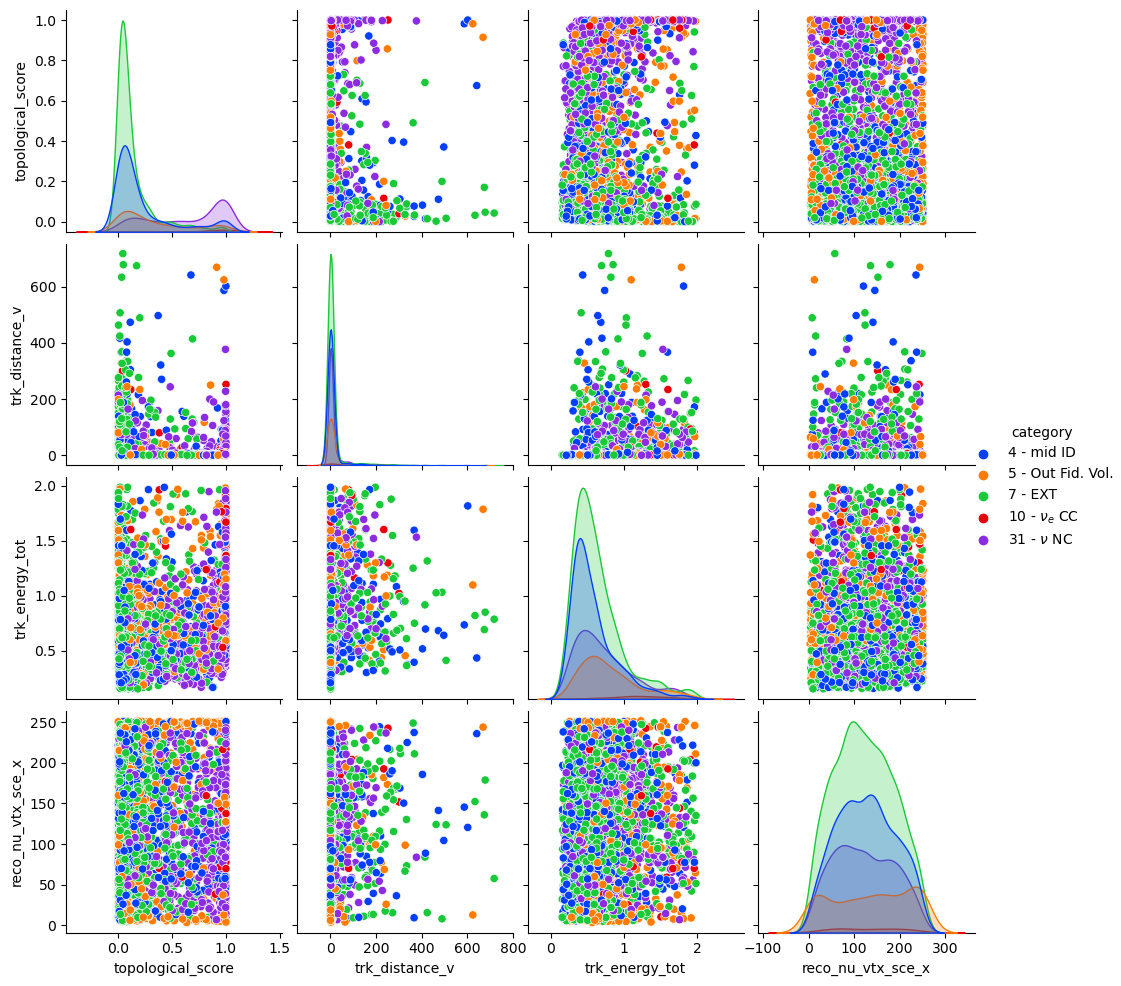

In [6]:
# Plot your background events using sns.pairplot

# List of categories (excluding signal) in text
ptype_no_mu = [r"mid ID", r"Out Fid. Vol.", r"EXT", r"$\nu_e$ CC", r"$\nu$ NC"]
fig = sns.pairplot(MC_EXT_VIS[variable_list], hue = 'category', palette = 'bright')

# Change location of legend
fig._legend.set_bbox_to_anchor((1.05, 0.5))

# Add Category number and type to legend
for t, l in zip(fig._legend.texts, ptype_no_mu):
   t.set_text(str(t.get_text()) + " - " + str(l))

In [7]:
# Make sure to delete dataframe copies if you no longer need them!
del MC_EXT_VIS
del MC_EXT_NO_SIG

# Exercise 6: Random Forest applications

Here we shall modify the shape of our data for its usage in a decision tree, then apply the *RandomForest* method from the skikit-learn package.

In [8]:
# Adjust data shape
features = ['_closestNuCosmicDist', 'trk_len_v', 'trk_distance_v', 'topological_score', 'trk_sce_end_z_v', 'trk_sce_end_y_v', 'trk_sce_end_x_v', 'trk_score_v', 'trk_llr_pid_score_v', 'trk_sce_start_z_v', 'trk_sce_start_y_v', 'trk_sce_start_x_v', 'reco_nu_vtx_sce_x', 'reco_nu_vtx_sce_y', 'reco_nu_vtx_sce_z', 'trk_energy_tot']
output = ['category']

# Setup new database, NEED MORE VALUES
MC_EXT_ML = MC_EXT.copy(deep = True)
MC_EXT_ML = MC_EXT.sample(int(len(MC_EXT)/10))

#or MC_EXT_ML.category == 10
# Remove muon neutrino and electron neutrino events.
MC_EXT_ML.drop(MC_EXT_ML[MC_EXT_ML.category == 21].index, inplace = True)
MC_EXT_ML.drop(MC_EXT_ML[MC_EXT_ML.category == 10].index, inplace = True)

MC_EXT_ML.head(5)
# Resetting the index again
MC_EXT_ML.reset_index(drop=True, inplace=True)

# Print length of dataframe,, with length N
print("Length of MC dataframe: ", len(MC_EXT_ML))

Length of MC dataframe:  31907


In [9]:
# Setting up input parameters for random forest.
X = MC_EXT_ML[features]
y = np.array(MC_EXT_ML['category'])

# Display shape of X and y, should be (N, 16) (N) where is number of samples.
print("(X) (y) shape:")
print(np.shape(X))
print(np.shape(y))
# Then split the data up into a "training set" and "test set" using train_test_split.
# Keep the random_state=1 in your arguments
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=1) # 80/20 training/test split

# Print the shape, should now be 
print("\n(x_train) (y_train) shape: ")
print(np.shape(x_train))
print(np.shape(y_train))


(X) (y) shape:
(31907, 16)
(31907,)

(x_train) (y_train) shape: 
(23930, 16)
(23930,)


Produce your randomforest model and fit it (dont worry, there is no explicit output, but make sure you haven't made your model too big! It shouldn't take any more than a couple of minutes at most to fit).

In [10]:
# Produce randomforest classifier model and fit to training data
# Keep the random_state=1 in your arguments
rf = RandomForestClassifier(max_depth =8, n_estimators = 1000, random_state=1)

# Fitting takes the input and "truth" data for classification purposes
rf.fit(x_train, y_train)

RandomForestClassifier(max_depth=8, n_estimators=1000, random_state=1)

Test the accuracies of your results:

In [11]:
# Produce predictions for the classification of your training dataset using your model:
y_pred = rf.predict(x_train)

# plot the accuracies of said predictions
print("Accuracy on training dataset:",metrics.accuracy_score(y_train, y_pred))
rf_acc_train = metrics.accuracy_score(y_train, y_pred)
y_pred = rf.predict(x_test)
print("Accuracy on testing dataset:",metrics.accuracy_score(y_test, y_pred))
rf_acc_test = metrics.accuracy_score(y_test, y_pred)

Accuracy on training dataset: 0.6663602173004597
Accuracy on testing dataset: 0.6443525134762442


In [12]:
# rf_test = RandomForestClassifier(max_depth =15, n_estimators = 2000, random_state=1)

# # Fitting takes the input and "truth" data for classification purposes
# rf_test.fit(x_train, y_train)

In [13]:
# # Produce predictions for the classification of your training dataset using your model:
# x_train_bonus = x_train
# y_train_bonus = y_train
# y_pred_bonus = rf_bonus.predict(x_train_bonus)

# # plot the accuracies of said predictions
# print("Accuracy on training dataset:",metrics.accuracy_score(y_train_bonus, y_pred_bonus))
# rf_acc_train = metrics.accuracy_score(y_train_bonus, y_pred_bonus)
# y_pred_bonus = rf_test.predict(x_test_bonus)
# print("Accuracy on testing dataset:",metrics.accuracy_score(y_test_bonus, y_pred_bonus))
# rf_acc_test = metrics.accuracy_score(y_test_bonus, y_pred_bonus) 

If your training accuracy is similar to your testing accuracy, this demonstrates that you haven't overfit your data!

#### Confusion matrix and variable importance

Produce a confusion matrix for your model to quantify its ability to predict your different interaction types.

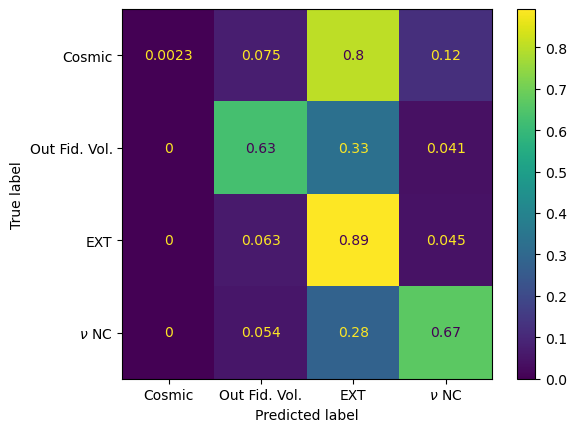

In [14]:
# For labelling your confusion matrix
ptype_no_mu_e = [r"Cosmic", r"Out Fid. Vol.", r"EXT", r"$\nu$ NC"]

# plot your confusion matrix
cm = confusion_matrix(y_test, y_pred,normalize = 'true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ptype_no_mu_e)
disp.plot()
plt.show()

Plot the importance of your different parameters.

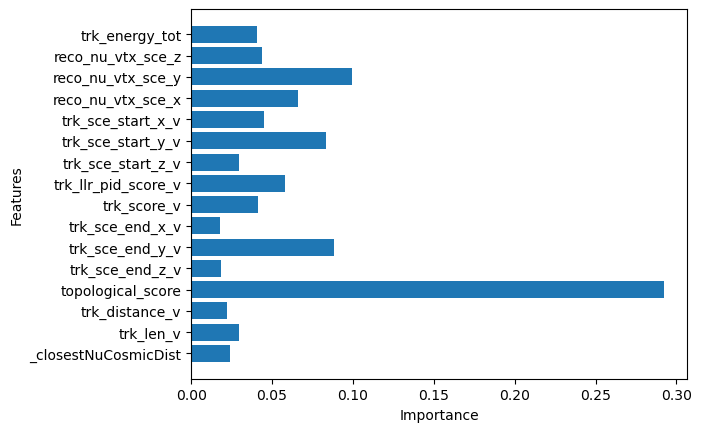

In [15]:
# Plot importance
importance = rf.feature_importances_
ytix = features

plt.barh(range(16), importance)
plt.yticks(range(16), features)
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

# Neutrino_functions.py

You are given access to a couple of template functions provided within Neutrino_functions.py, which may be helpful in completing this lab. One such function is 'Neutrino_functions.histogram_plot', which can be seen below, but you can create your own functions if you wish.

In [16]:
# Simple histogram plot of multiple variables in a grid
def multi_hist_plot_fnc(data_frame, columns, width=20, height=15, x_num = 1, y_num = 1):
    fig, axs = plt.subplots(y_num, x_num, figsize=(width, height))
    axs = axs.flatten()  # Flatten to easily iterate
    BIN = 40
    
    for i, param in enumerate(columns):
        sns.histplot(
            data=data_frame, 
            x=param, 
            multiple="stack", 
            hue="category", 
            palette='deep', 
            weights=data_frame['weight'], 
            bins=BIN, 
            legend=False, 
            ax=axs[i]
        )
        axs[i].set_xlabel(param)
        axs[i].set_ylabel("Events")
        axs[i].set_xlim([np.min(data_frame[param]), np.max(data_frame[param])])
        axs[i].set_yscale('linear')  # Change to 'log' if needed
        axs[i].grid(True)

    # Hide any unused subplots if columns < 16
    for j in range(len(columns), x_num * y_num):
        axs[j].axis('off')
    
    plt.tight_layout()
    plt.show()


Modify selection cuts. Remember to cut the same variables in both data sets.

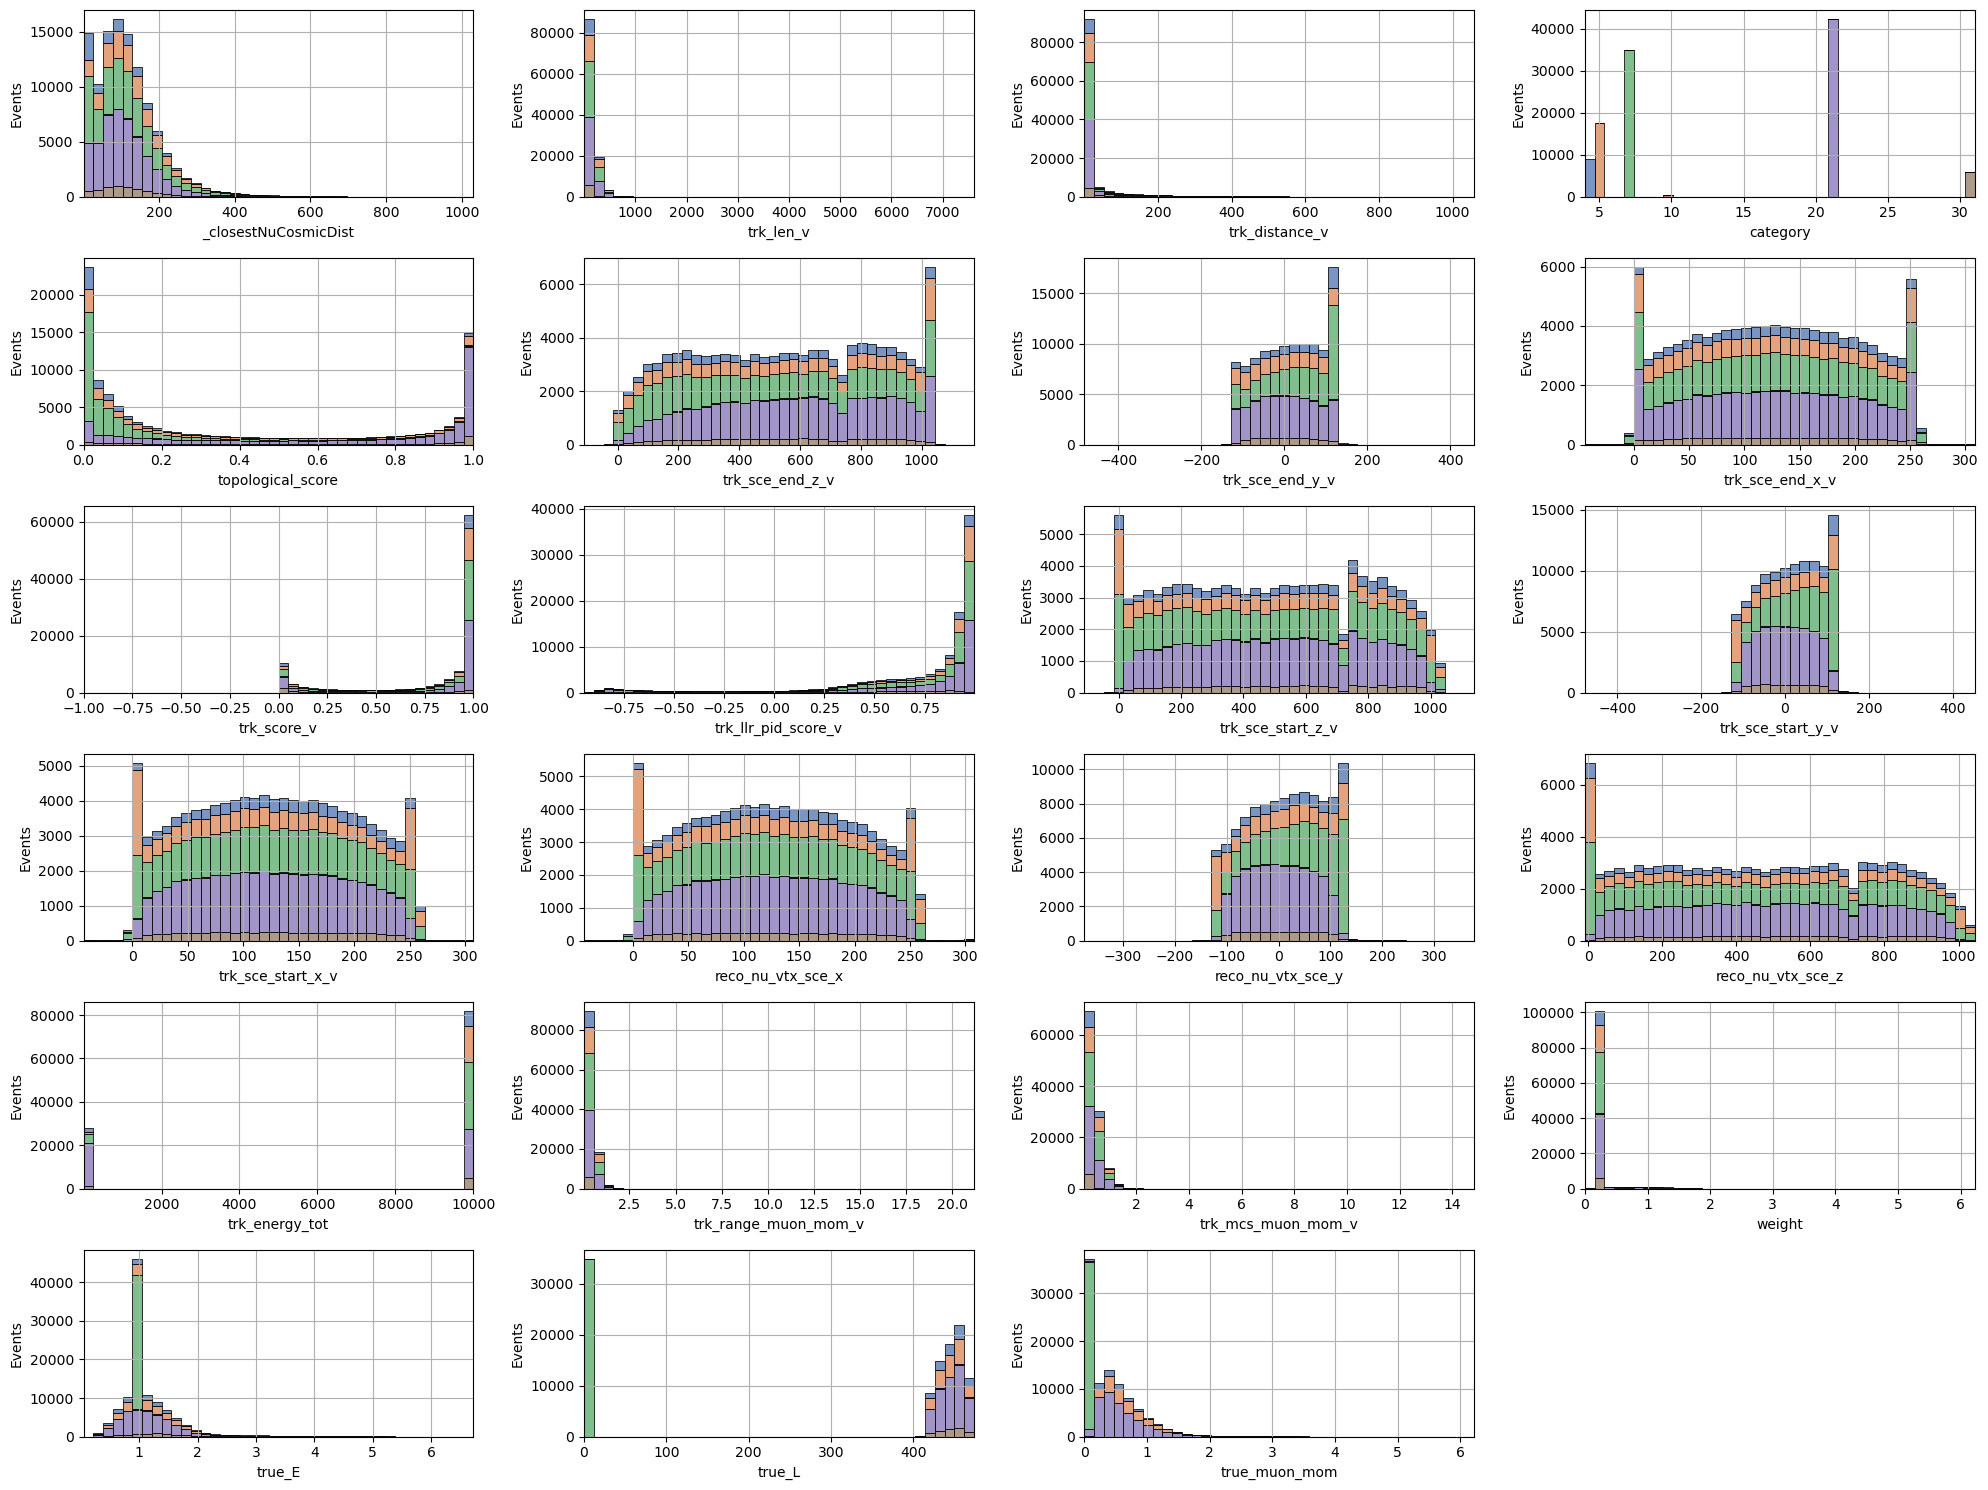

In [152]:
multi_hist_plot_fnc(MC_EXT, MC_EXT.columns, x_num = 4, y_num = 6)

In [18]:
def Selections(frame, cut_variable, lower_con, upper_con):
    
    # Basic variables present in dataframe 
    trk_start_x_v = frame['trk_sce_start_x_v']        # cm
    trk_start_y_v = frame['trk_sce_start_y_v']        # cm
    trk_start_z_v = frame['trk_sce_start_z_v']        # cm
    trk_end_x_v = frame['trk_sce_end_x_v']            # cm
    trk_end_y_v = frame['trk_sce_end_y_v']            # cm
    trk_end_z_v = frame['trk_sce_end_z_v']            # cm
    reco_x = frame['reco_nu_vtx_sce_x']               # cm
    reco_y = frame['reco_nu_vtx_sce_y']               # cm
    reco_z = frame['reco_nu_vtx_sce_z']               # cm
    topological = frame['topological_score']          # N/A
    trk_score_v = frame['trk_score_v']                # N/A
    trk_dis_v = frame['trk_distance_v']               # cm
    trk_len_v = frame['trk_len_v']                    # cm
    trk_energy_tot = frame['trk_energy_tot']          # GeV 
    
    cut_variable_data = frame[cut_variable]
    # select the conditions you want to apply, here is an initial condition to get you started.
    selection =  ((cut_variable_data > lower_con) & (cut_variable_data < upper_con))
    
    # Apply selection on dataframe
    frame = frame[selection]
    
    return frame

def Rejections(frame, cut_variable, lower_con, upper_con):
    cut_variable_data = frame[cut_variable]
    # select the conditions you want to apply, here is an initial condition to get you started.
    selection =  ((cut_variable_data < lower_con) | (cut_variable_data > upper_con))
    
    # Apply selection on dataframe
    frame = frame[selection]
    
    return frame

## Calls the selection function on the dataframes

144211
trk_sce_end_z_v 142265
trk_distance_v 134985
trk_sce_end_x_v 134927
trk_sce_end_y_v 123125
reco_nu_vtx_sce_x 120697
_closestNuCosmicDist 120661
trk_sce_start_z_v 106572
trk_mcs_muon_mom_v 106462
trk_sce_start_y_v 101686
topological_score 76268
trk_energy_tot 76268
reco_nu_vtx_sce_y 76268
trk_range_muon_mom_v 76226
trk_sce_start_x_v 76224
trk_score_v 76219
trk_llr_pid_score_v 76219
reco_nu_vtx_sce_z 76028
trk_len_v 76028
Cut Efficiency: 0.5271997281760753
Purity: 0.8682590624506761


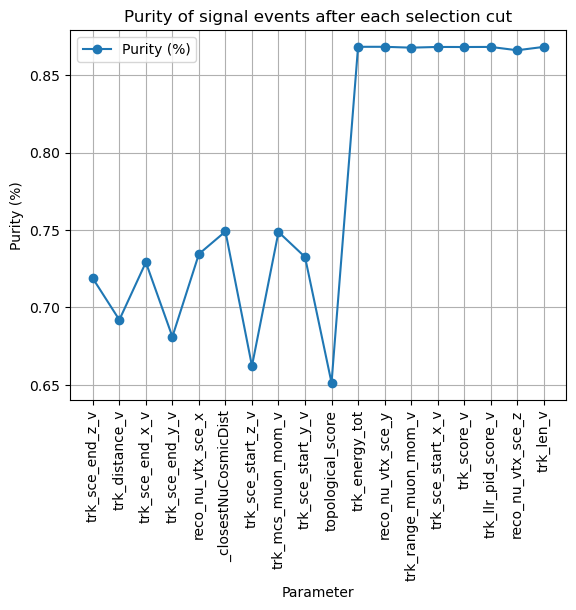

In [303]:
MC_EXT_CUT = MC_EXT.copy()
DATA_CUT = data.copy()
OSC_DATA_CUT = osc_data.copy()
# Apply cuts for multiple parameters to MC_EXT_CUT and DATA_CUT
MC_EXT_CUT = Selections(MC_EXT_CUT,'trk_energy_tot', 0, 2)
DATA_CUT = Selections(DATA_CUT,'trk_energy_tot', 0, 2)
OSC_DATA_CUT = Selections(OSC_DATA_CUT,'trk_energy_tot', 0, 2)

# Define parameter ranges
cut_ranges = {
    'trk_sce_end_z_v': (15, 985), #1
    'trk_distance_v': (0, 70), #2
    'trk_sce_end_x_v': (0, 260), #3
    'trk_sce_end_y_v': (-105, 105), #4
    'reco_nu_vtx_sce_x': (10, 250), #5
    '_closestNuCosmicDist': (0, 700), #6
    'trk_sce_start_z_v': (100, 900), #7
    'trk_mcs_muon_mom_v': (0, 1.5), #8
    'trk_sce_start_y_v': (-105, 105), #9
    'topological_score': (0.2, 1.5), #10
    'trk_energy_tot': (0, 2), #11
    'reco_nu_vtx_sce_y': (-115, 115), #12
    'trk_range_muon_mom_v': (0, 1.5), #13
    'trk_sce_start_x_v': (0, 260), #14
    'trk_score_v': (0, 1.5), #15
    'trk_llr_pid_score_v': (-1, 1), #16
    'reco_nu_vtx_sce_z': (100, 900), #17
    'trk_len_v': (0, 1000), #18
}

MC_CUT_PURITY = []

print(len(MC_EXT_CUT))
for param, (low, high) in cut_ranges.items():
    curr_len_MC = len(MC_EXT_CUT)
    curr_len_DATA = len(DATA_CUT)
    MC_EXT_CUT = Selections(MC_EXT_CUT, param, low, high)
    DATA_CUT = Selections(DATA_CUT, param, low, high)
    print(param, len(MC_EXT_CUT))
    OSC_DATA_CUT = Selections(OSC_DATA_CUT, param, low, high)
    MC_CUT_PURITY.append(len(MC_EXT_CUT[MC_EXT_CUT.category == 21]) / curr_len_MC)
    
num_cuts = range(1, len(cut_ranges) + 1)
fig, ax = plt.subplots()
ax.plot(num_cuts, MC_CUT_PURITY, marker='o')
ax.set_xticks(num_cuts)
ax.set_xticklabels(list(cut_ranges.keys()), rotation = 90)
ax.grid(True)
ax.set_xlabel("Parameter")
ax.set_ylabel("Purity (%)")
ax.set_title("Purity of signal events after each selection cut")
ax.legend(["Purity (%)"])
CUT_EFFICIENCY = len(MC_EXT_CUT)/ len(MC_EXT_CUT_OG)
print(f"Cut Efficiency: {CUT_EFFICIENCY}")
event_count = (MC_EXT_CUT['category'] == 21).sum()
PURITY = event_count / len(MC_EXT_CUT)
print(f"Final purity: {PURITY}")
MC_EXT_OSC = MC_EXT_CUT.copy()
DATA_OSC = DATA_CUT.copy()
MB_DATA_OSC = OSC_DATA_CUT.copy()

In [293]:
print(len(MC_EXT_CUT))
print(len(DATA_CUT))
print(len(OSC_DATA_CUT))

76028
14399
76028


<function dict.keys>

# Plot all variables and decide on selection cuts
Here is the section with the example histogram plots for each variable. Create a new cell and implement your own function to plot all the histograms.

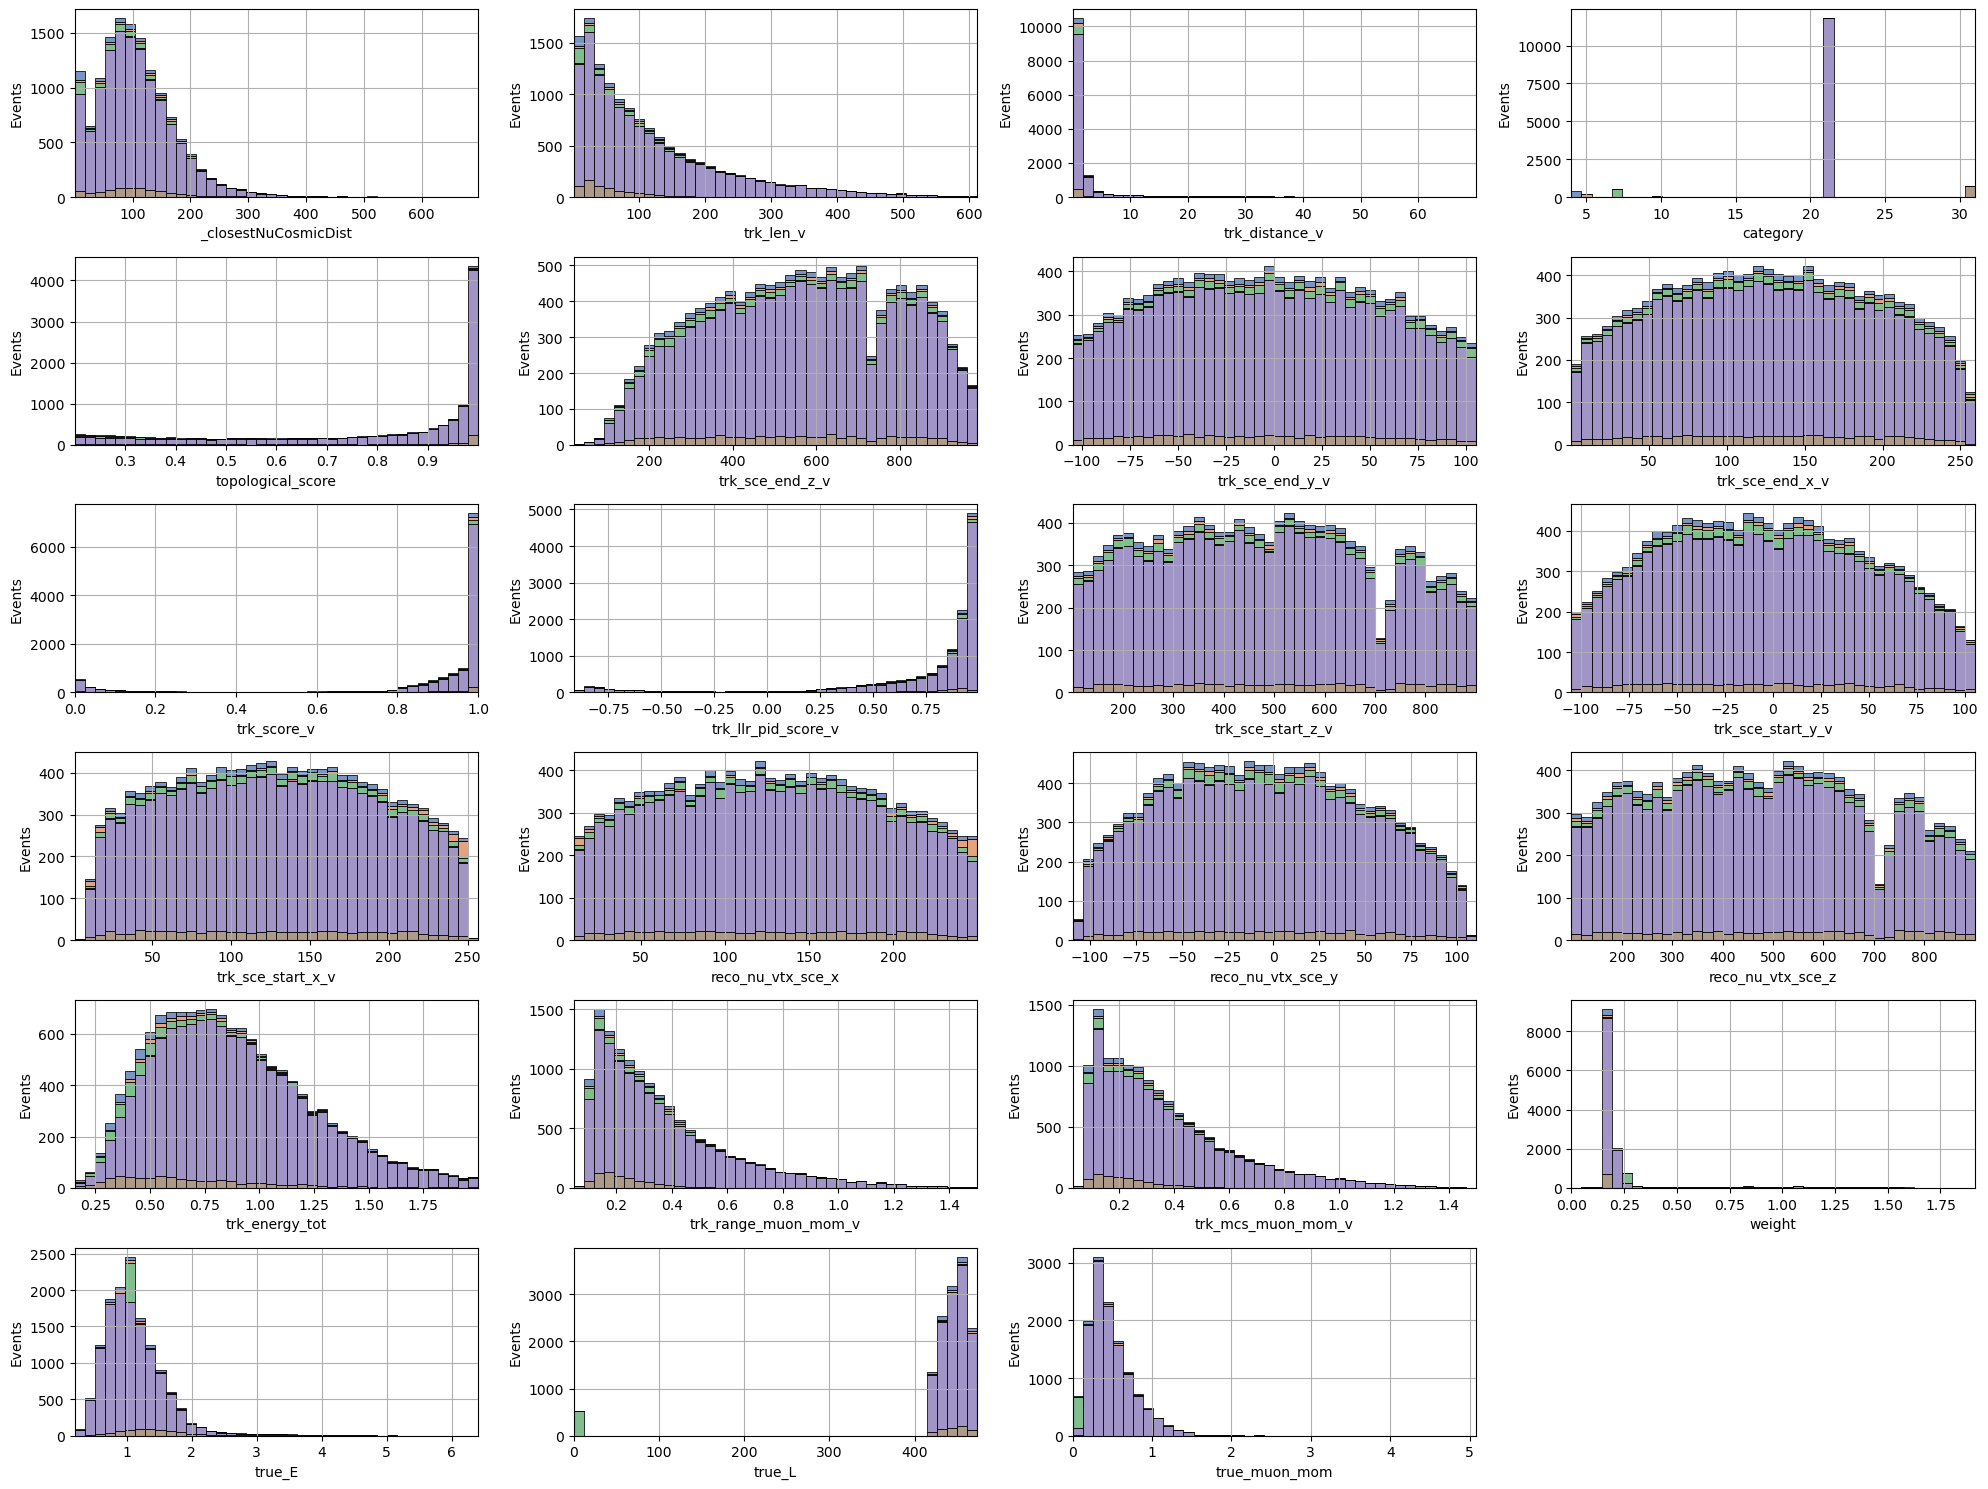

In [304]:
multi_hist_plot_fnc(MC_EXT_CUT, MC_EXT_CUT.columns, x_num = 4, y_num = 6)

In [23]:
#multi_hist_plot_fnc(DATA_CUT, DATA_CUT.columns, x_num = 4, y_num = 6)

In [210]:
# Simple histogram plot of one variable.
def single_hist_plot_fnc(data_frame, x_variable):
    BIN = 30
    plt.figure(figsize=(20,15))
    i = sns.histplot(data=data_frame, x=x_variable, multiple="stack", hue="category", palette = 'deep', weights = data_frame['weight'], bins = BIN, legend = False)
    i.set(xlabel='trk_energy_tot', ylabel = "Events")

    #plt.yscale('log')
    plt.xlim([np.min(data_frame[x_variable]), np.max(data_frame[x_variable])])
    plt.legend(title='Run 3',fontsize=16, loc='upper right', labels=[r"$\nu$ NC", r"$\nu_{\mu}$ CC", r"$\nu_e$ CC", r"EXT", r"Out. fid. vol.", r"mis ID"])
    plt.show(i)

# Exercise 8: Check the purity and efficiency of the sample
It is recommended to plot purity and efficiency after each variable cut.

**HINT:** Function Selection() has commented lines of code that you may find useful for purpose of plotting changes in purity/efficiency after every cut.

# Exercise 9: Plot the energy spectrums here and normalise

Final representation of MC and data after applying the cuts.

In [212]:
def data_binning(osc_data, mc_data, x_variable):
    BIN = 30
    bin_edges = np.linspace(np.min(osc_data[x_variable]), np.max(osc_data[x_variable]), BIN + 1)
    osc_counts, _ = np.histogram(osc_data[x_variable], bins=bin_edges, weights=osc_data["weight"])
    mc_counts, _ = np.histogram(mc_data[x_variable], bins=bin_edges, weights=mc_data["weight"])
    
    # Compute bin centers
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Compute Poisson error bars (sqrt of weights sum)
    errors = 0.15 * mc_counts
    return bin_centers, mc_counts, osc_counts, errors

def unweighted_data_binning(osc_data, mc_data, x_variable):
    BIN = 30
    bin_edges = np.linspace(np.min(osc_data[x_variable]), np.max(osc_data[x_variable]), BIN + 1)
    osc_counts, _ = np.histogram(osc_data[x_variable], bins=bin_edges) #, weights=osc_data["weight"])
    mc_counts, _ = np.histogram(mc_data[x_variable], bins=bin_edges, weights=mc_data["weight"])
    
    # Compute bin centers
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Compute Poisson error bars (sqrt of weights sum)
    errors = 0.15 * mc_counts
    return bin_centers, mc_counts, osc_counts, errors

In [213]:
def weighted_multi_histplot(osc_data, mc_data, x_variable, plot = True):
    BIN = 30
    bin_edges = np.linspace(np.min(osc_data[x_variable]), np.max(osc_data[x_variable]), BIN + 1)
    osc_counts, _ = np.histogram(osc_data[x_variable], bins=bin_edges, weights=osc_data["weight"])
    mc_counts, _ = np.histogram(mc_data[x_variable], bins=bin_edges, weights=mc_data["weight"])
    
    # Compute bin centers
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Compute Poisson error bars (sqrt of weights sum)
    mc_errors = 0.15 * mc_counts

    # Plot histogram with seaborn
    if plot:
        plt.figure(figsize=(20,15))

        i = sns.histplot(data=osc_data, x=x_variable, multiple="stack", #hue="category", palette='deep', 
             weights = osc_data['weight'], color = 'grey', bins=BIN, legend=False)

        j = sns.histplot(data=mc_data, x=x_variable, multiple="stack", hue="category", palette='deep',
             weights = mc_data['weight'], bins=BIN, legend=False)
        
        i.set(xlabel='trk_energy_tot', ylabel="Events")

  #      plt.plot(bin_centers, mc_counts * data_frame['weight'], label="Data", marker='o', color="k", linestyle= "")
        bar_width = (bin_edges[1] - bin_edges[0])  # Width of each bin
        plt.errorbar(bin_centers, mc_counts, yerr=mc_errors, fmt='o', color='black', label="Stat. Error")

        # Adjustments
        plt.xlim([np.min(osc_data[x_variable]), np.max(osc_data[x_variable])])
        plt.legend(title='Run 3', fontsize=16, loc='upper right', labels=[
            r"$\nu_{\mu}$ pre-osc", r"$\nu_{\mu}$ mc"])
        plt.show()
    return bin_centers, osc_counts, mc_counts, mc_errors

In [214]:
def unweighted_multi_histplot(osc_data, mc_data, x_variable, plot = True):
    BIN = 30
    bin_edges = np.linspace(np.min(osc_data[x_variable]), np.max(osc_data[x_variable]), BIN + 1)
    osc_counts, _ = np.histogram(osc_data[x_variable], bins=bin_edges)
    mc_counts, _ = np.histogram(mc_data[x_variable], bins=bin_edges, weights=mc_data["weight"])
    
    # Compute bin centers
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Compute Poisson error bars (sqrt of weights sum)
    mc_errors = 0.15 * mc_counts
  #  osc_errors = np.sqrt(np.histogram(osc_data[x_variable], bins=bin_edges, weights=osc_data["weight"] ** 2)[0])

    # Plot histogram with seaborn
    if plot:
        plt.figure(figsize=(20,15))

        i = sns.histplot(data=osc_data, x=x_variable, multiple="stack", #hue="category", palette='deep', 
             color = 'grey', bins=BIN, legend=False)

        j = sns.histplot(data=mc_data, x=x_variable, multiple="stack", hue="category", palette='deep',
             weights = mc_data['weight'], bins=BIN, legend=False)
        
        i.set(xlabel='trk_energy_tot', ylabel="Events")

       # plt.plot(bin_centers, data_counts * data_frame['weight'], label="Data", marker='o', color="k", linestyle= "")
        bar_width = (bin_edges[1] - bin_edges[0])  # Width of each bin
        plt.errorbar(bin_centers, mc_counts, yerr=mc_errors, fmt='o', color='black', label="Stat. Error")

        # Adjustments
        plt.xlim([np.min(osc_data[x_variable]), np.max(osc_data[x_variable])])
        plt.legend(title='Run 3', fontsize=16, loc='upper right',labels=["Expected count", r"$\nu$ NC", r"$\nu_{\mu}$ CC", 
                                                 r"$\nu_e$ CC", r"EXT", r"Out. fid. vol.", r"mis ID", r"Uncertainty"]) 
                   #labels=[r"$\nu_{\mu}$ pre-osc", r"$\nu_{\mu}$ mc"])
        plt.show()
    return bin_centers, osc_counts, mc_counts, mc_errors

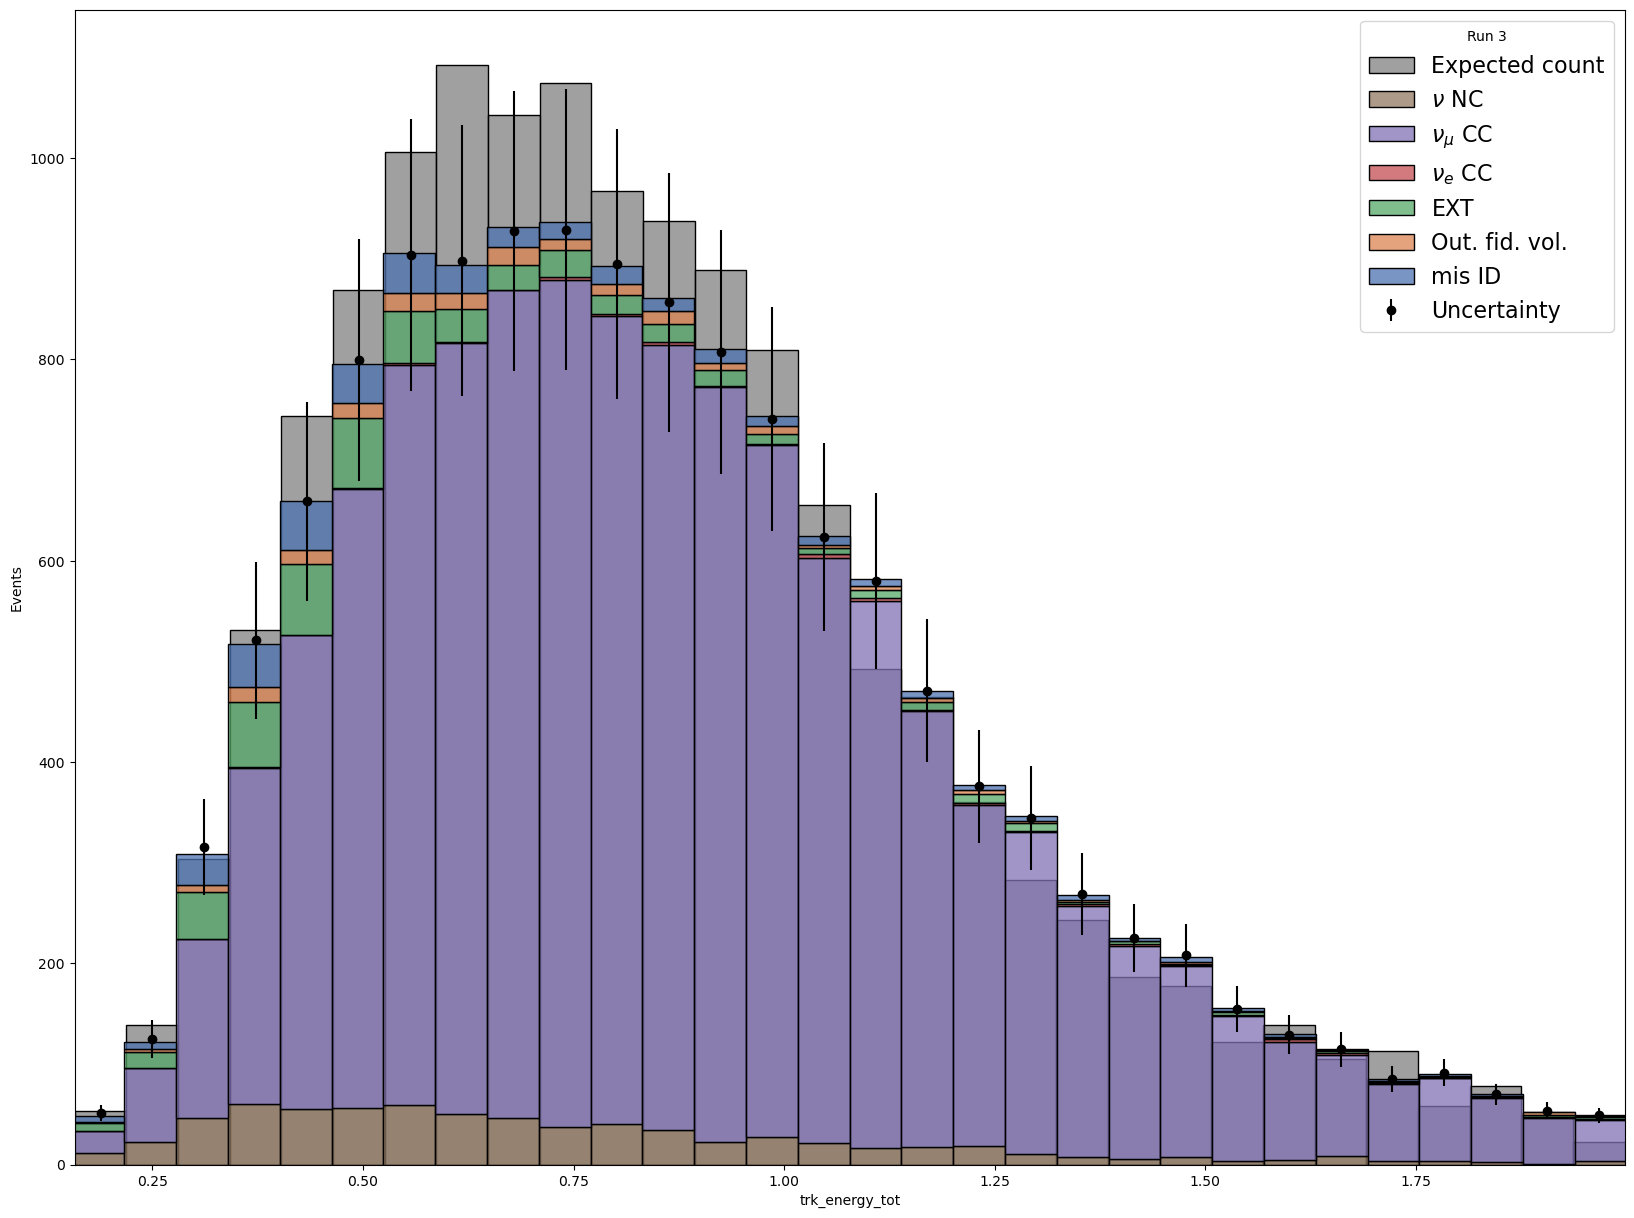

In [263]:
x, osc_counts, mc_counts, mc_errors = unweighted_multi_histplot(DATA_CUT, MC_EXT_CUT, 'trk_energy_tot')

# Exercise 10: Oscillation and fitting

### a) Define functions requires for Oscillation analysis, test that they work!


In [285]:
# oscillation function
def oscillation_function(sin_2theta_sq, del_m_21_sq, length, energy):
    p_no_osc = 1 - (sin_2theta_sq * (np.sin(1.27 * del_m_21_sq * length * 10**(-3) / energy))**2)
    return p_no_osc

def oscillation_function_4(sin_2theta_mu_e, del_m_21_sq, length, energy):
    sin_2theta_sq = (4 * sin_2theta_mu_e)/ 0.24
    p_no_osc = 1 - (sin_2theta_sq * (np.sin(1.27 * del_m_21_sq * length * 10**(-3) / energy))**2)
    return p_no_osc

In [286]:
# muon disappearance application to reconstructed neutrino energy
def nu_mu_oscillation(weights, sin_2theta_sq, del_m_21, length, energy):
    osc_weights = weights * oscillation_function(sin_2theta_sq, del_m_21, length, energy)
    return osc_weights

def nu_mu_oscillation_4(weights, sin_2theta_mu_e, del_m_21, length, energy):
    osc_weights = weights * oscillation_function_4(sin_2theta_mu_e, del_m_21, length, energy)
    return osc_weights

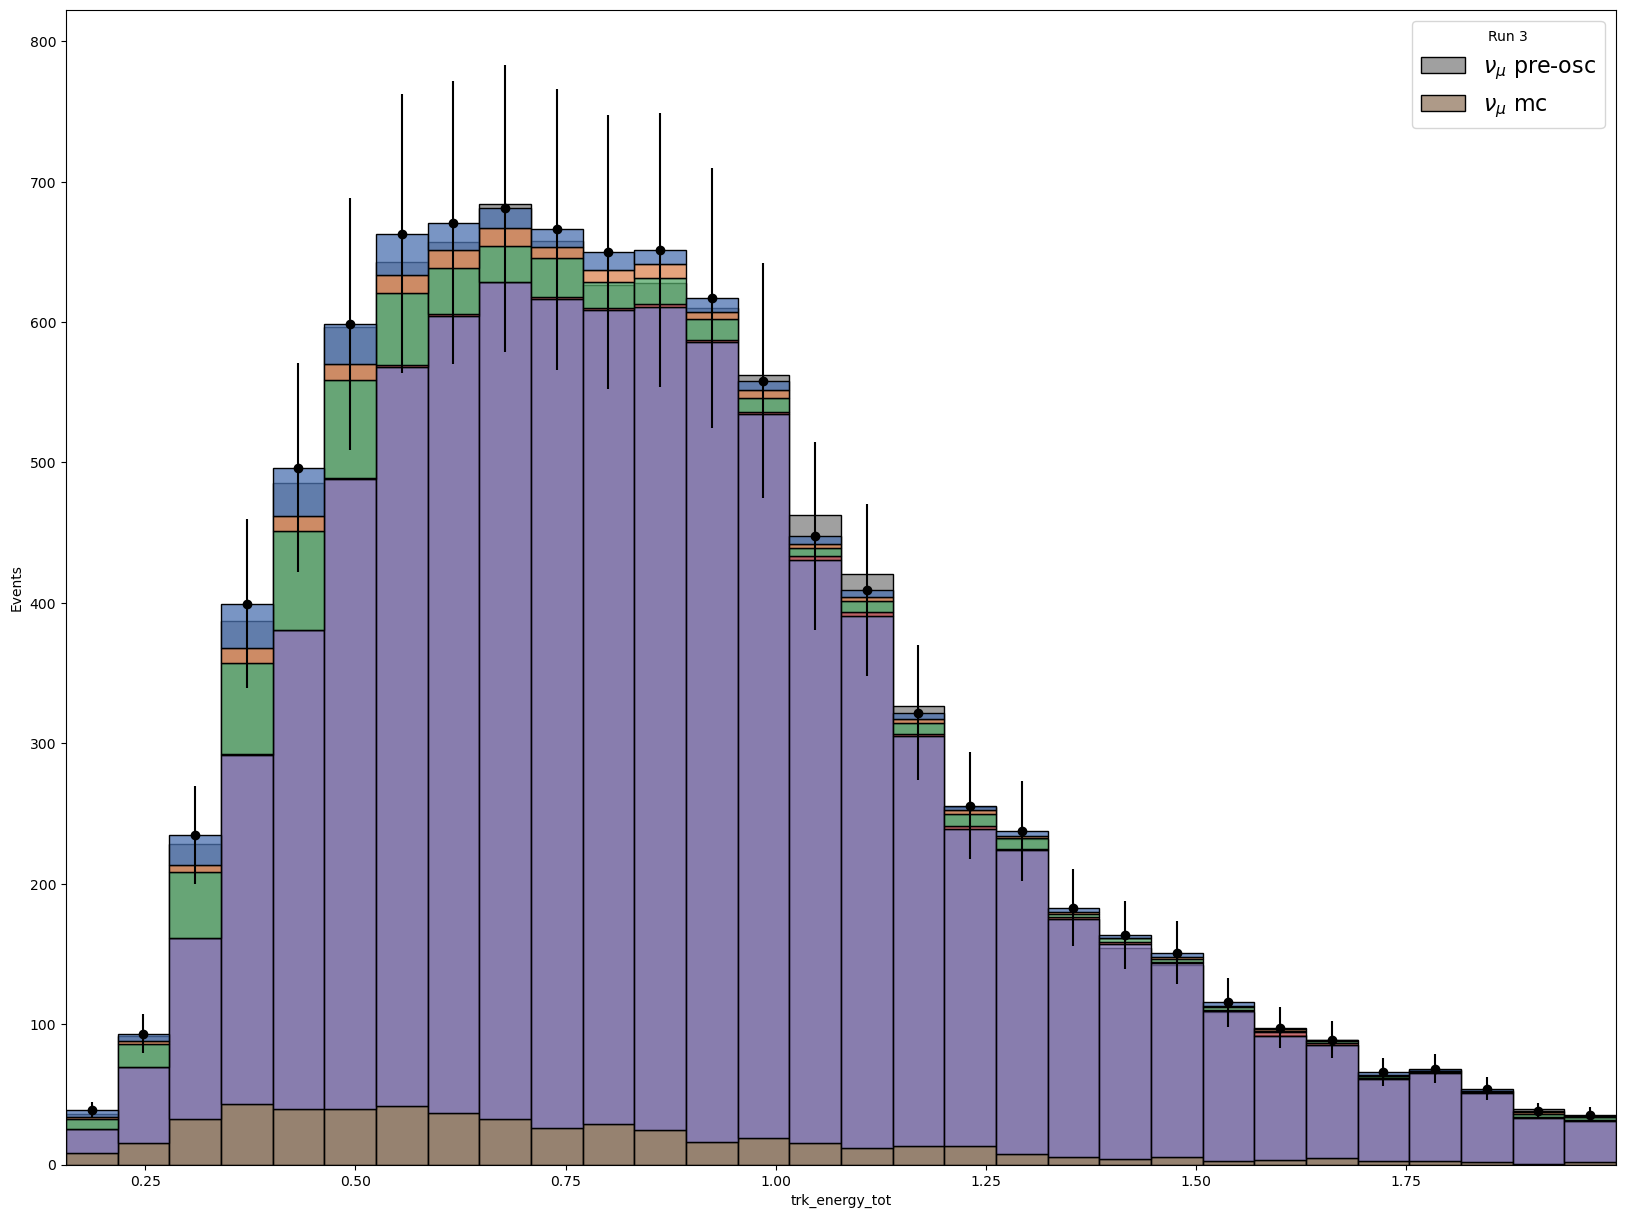

In [265]:
test_theta = 0.54
test_mass = 11
MC_EXT_OSC_COPY = MC_EXT_OSC.copy()
MC_EXT_OSC_COPY['weight'] = nu_mu_oscillation(MC_EXT_OSC_COPY['weight'], test_theta, test_mass, MC_EXT_OSC_COPY['true_L'], MC_EXT_OSC_COPY['true_E'])
x, osc_count, mc_count, mc_error = weighted_multi_histplot(MB_DATA_OSC, MC_EXT_OSC_COPY, 'trk_energy_tot')

In [119]:
def chi_squared(params, observed, expected, weight = True, model = 3):
    """
    Chi-squared function for neutrino oscillation fit.
    
    Parameters:
    - params: List or array with [theta, del_m21] to be optimized.
    - observed: DataFrame containing observed data.
    - expected: Expected values (theoretical model).
    - uncertainty: Measurement uncertainties.
    
    Returns:
    - chi-squared value (float).
    """
    sin_2theta_sq, del_m21_sq = params  # Extract parameters
    
    osc_mc_data = observed.copy()
    if model == 3:
        osc_mc_data['weight'] = nu_mu_oscillation(
            observed['weight'], sin_2theta_sq, del_m21_sq, observed['true_L'], observed['true_E'])
    if model == 4:
        osc_mc_data['weight'] = nu_mu_oscillation_4(
            observed['weight'], sin_2theta_sq, del_m21_sq, observed['true_L'], observed['true_E'])        
    if weight:
        x, osc_count, mc_count, mc_error = data_binning(expected, osc_mc_data, 'trk_energy_tot')
    else:
        x, osc_count, mc_count, mc_error = unweighted_data_binning(expected, osc_mc_data, 'trk_energy_tot')

    # if len(osc_mc_data['weight']) != len(expected) or len(uncertainty) != len(expected):
    #     raise ValueError("Length mismatch between observed, expected, and uncertainty.")

    chi2 = np.sum(((osc_count - mc_count) ** 2) / (mc_error ** 2))
    return chi2

def chi_squared_plus_x_finder(chi_squared_values, lowest_chi_squared, x):
    """
    Find indices where chi-squared is one unit greater than the minimum.

    Args:
        chi_squared_values : Chi-squared values.
        chi_squared_min (float): Minimum chi-squared value.

    Returns:
        tuple: Indices where chi-squared is one unit greater than the minimum.
    """
    chi_condition = np.round(lowest_chi_squared, 3) + x
    chi_squared_plus1_condition = np.round(
        chi_squared_values, 3) == chi_condition

    chi_plus1_values_index = np.where(chi_squared_plus1_condition)
    return chi_plus1_values_index

def gen_chi_grid(x_vals, y_vals, df, weight = True):
    sim_df, expected_df = df
        # Create a 2D array to store chi-squared values
    chi2_grid = np.zeros((len(x_vals), len(y_vals)))

    # Compute chi-squared for each grid point
    for j, x_val in enumerate(x_vals):
        for i, y_val in enumerate(y_vals):
            chi2_grid[i, j] = chi_squared([y_val, x_val], sim_df, expected_df)
    return chi2_grid

In [124]:
def contour_plotting(sin_2theta_sq_values, del_m21_sq_values, dfs, cmap = False, weight_cond = False, error_cont = False, confidence_cont = False, log_scale = False, neutrino_model = 3):
    df1, df2 = dfs # MC, ACTUAL

    chi2_grid = np.zeros((len(del_m21_sq_values), len(sin_2theta_sq_values)))

    # Compute chi-squared for each grid point
    for j, sin_2theta_sq in enumerate(sin_2theta_sq_values):
        for i, del_m21_sq in enumerate(del_m21_sq_values):
            chi2_grid[i, j] = chi_squared([sin_2theta_sq, del_m21_sq], df1, df2, weight_cond, model = neutrino_model)

    #chi2_grid = gen_chi_grid(sin_2theta_sq_values, del_m21_sq_values, [MC_EXT_OSC, DATA_OSC])
    reduced_chi_squared = chi2_grid / (len(sin_2theta_sq_values) - 2)
    chi_squared_min = np.min(chi2_grid)
    print(chi_squared_min)
    #chi_sq_plus1 = chi2_grid[chi_squared_plus_x_finder(chi2_grid, min_chi_sq,1)]

    # Create contour plot
    #plt.figure(figsize=(8, 6))
    if cmap:
        contour = plt.contourf(sin_2theta_sq_values, del_m21_sq_values, chi2_grid, levels=50, cmap='viridis')
        plt.colorbar(label=r'$\chi^2$')
    if error_cont:
        chi_squared_levels = [chi_squared_min+2.3, chi_squared_min+6.18, chi_squared_min+11.83]
        for level in chi_squared_levels:
            contour_line = plt.contour(sin_2theta_sq_values,del_m21_sq_values,
                                    chi2_grid, levels=[level],colors='k', linestyles='dashed')

    # Confidence level thresholds
    if confidence_cont:
        conf_levels_chi = [4.605, 5.991, 9.210]  # 90%, 95%, 99% confidence
        conf_levels = ["90%", "95%", "99%"]
        thresholds = [chi_squared_min + d for d in conf_levels_chi]
        colors = ['blue', 'green', 'red']
        cont_labels = {thresholds[i]: conf_levels[i] for i in range(3)}

        for i in range(3):
            contour_line = plt.contour(sin_2theta_sq_values, del_m21_sq_values,
                                       chi2_grid, levels=[thresholds[i]], 
                                       colors=colors[i], linestyles='dashed')

            # Add inline labels
            plt.clabel(contour_line, inline=True, fontsize=8, fmt=cont_labels)

         #   plt.clabel(contour_line, inline=True, fontsize=10, fmt="%.2f")
       # plt.legend(labels = cont_labels)

    if log_scale:
        plt.loglog()
    # Add labels
    # plt.ylabel(r'$\Delta m^2_{21}$')
    # plt.xlabel(r'$sin^2(2\theta)$')
    # plt.title(r'$\chi^2$ Contour Plot')
    # Show the plot
 #   plt.show()
    return chi2_grid


0.31286810113551994


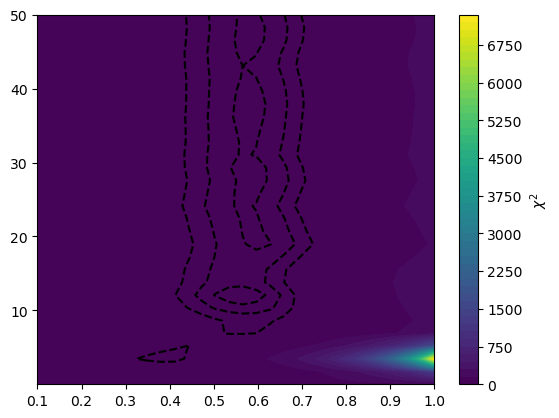

In [249]:
sin_2theta_sq_values = np.linspace(0.1, 1, 30)  # Adjust range as needed
del_m21_sq_values = np.linspace(0.0001, 50, 30)  # Adjust range as needed
placeholder = contour_plotting(sin_2theta_sq_values, del_m21_sq_values, [MC_EXT_OSC,MB_DATA_OSC], cmap = True, weight_cond = True,
                               error_cont = True)

In [281]:
# Initial guesses
del_m21_start = 11
theta_start = 0.54

# Minimize chi-squared
result = fmin(chi_squared, x0=[theta_start, del_m21_start], args=(MC_EXT_OSC, MB_DATA_OSC, True), full_output=True, disp=True)

# Optimized parameters
optimized_theta, optimized_del_m21 = result[0]
print(f"Optimized theta: {optimized_theta}, Optimized Δm_21: {optimized_del_m21}")
# 0.5621 sin2theta
# 11.516 m21
# 0.183 red chisq

Optimization terminated successfully.
         Current function value: 0.102191
         Iterations: 29
         Function evaluations: 57
Optimized theta: 0.5638933474580052, Optimized Δm_21: 11.701288118833371


40.64933822564171


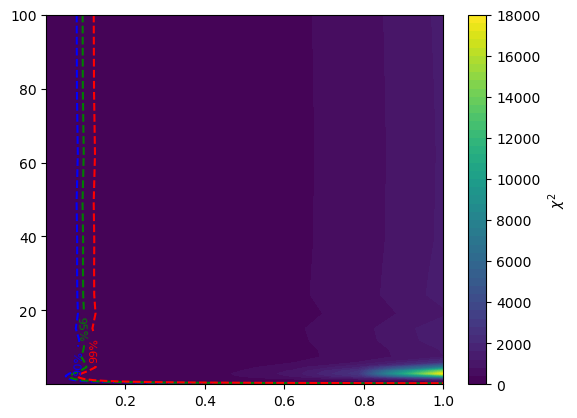

In [280]:
sin_2theta_sq_values = np.linspace(0.01, 1, 30)  # Adjust range as needed
del_m21_sq_values = np.linspace(0.001, 50, 30)  # Adjust range as needed

sin_2theta_sq_values = np.logspace(-3, 0, 30)  # Adjust range as needed
del_m21_sq_values = np.logspace(-2, 2, 40)  # Adjust range as needed
placeholder = contour_plotting(sin_2theta_sq_values, del_m21_sq_values, [MC_EXT_OSC,DATA_OSC], weight_cond = False,
                               error_cont = False, confidence_cont = True, cmap = True)

# Exercise 11/12: Oscillation parameter scan, contour plotting, closure test.

### Closure test, create your oscillation parameter scanning code, and find minimum values for chi squared!

In [43]:
# Selection cuts on oscillated data

In [44]:
# Function that oscillates and calculates chi squared for set delM21 and sin^2(2theta)

In [45]:
# Function that loops the above function across range of values of delM21 and sin^2(2theta)

In [46]:
# plot contourf function and find minimum!

Apply your above defined functions, and represent your result with matplotlib's contour and fcontour.

In [47]:
# oscillate MC wrt to true data

In [48]:
# contourf application

### Bonus: Minimise

Minimise your chi square value, determining the parameters of 'best fit'

### Confidence levels and parameter minima. 
Determine confidence levels, and find the parameter values that correspond to the lowest chi squared value within your range.with

In [49]:
# contour application, with correct confidence levels.

In [50]:
# find lowest chi squared value within range and plot with CL, or contourf plot.

# Exercise 13/14: 3+1 Framework Neutrino disappearance.

40.649439044399365


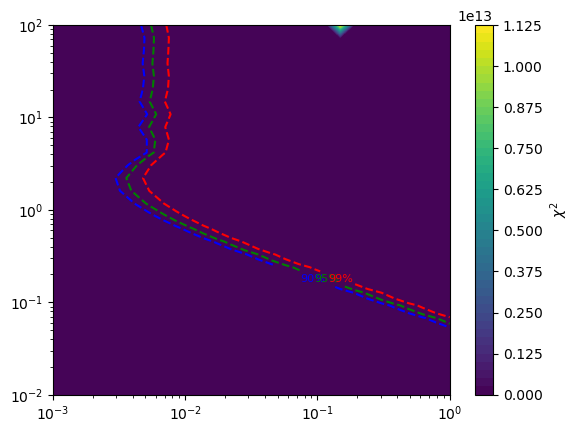

In [290]:
# Produce your new oscillation parameter, which should be sin^2(2*theta_ue)
sin_2theta_ue = np.logspace(-3, 0, 30)  # Adjust range as needed

a = contour_plotting(sin_2theta_ue, del_m21_sq_values, (MC_EXT_OSC, DATA_OSC), confidence_cont=True, cmap = True, log_scale= True, neutrino_model= 4)

# Compare your result with MiniBooNE

Results are extracted from MiniBooNE (orange) and LSND (blue)

40.05404389502243


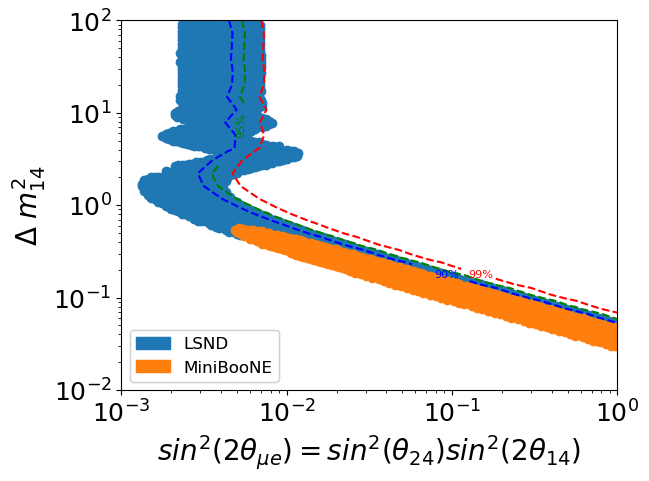

In [296]:
sin_2theta_uu = np.logspace(-3, 0, 30)  # Adjust range as needed

del_m21_sq_values = np.logspace(-2, 2, 30)  # Adjust range as needed

# Load data
LSND_data = pd.read_csv('./data/DataSet_LSND.csv').to_numpy()
MiniBooNE_data = pd.read_csv('./data/DataSet_MiniBooNE.csv').to_numpy()

# Plot data
plt.plot(LSND_data[:,0],LSND_data[:,1],'o')
plt.plot(MiniBooNE_data[:,0],MiniBooNE_data[:,1],'o')

# Producing MiniBooNE/LSND legend
LSND_path = mpatches.Patch(color='tab:blue', label = 'LSND')
MINI_path = mpatches.Patch(color='tab:orange', label = 'MiniBooNE')
first_legend = plt.legend(handles=[LSND_path, MINI_path], loc = 'lower left', fontsize = 12)
plt.gca().add_artist(first_legend)

a = contour_plotting(sin_2theta_uu, del_m21_sq_values, (MC_EXT_OSC, DATA_OSC), confidence_cont=True, log_scale= True, neutrino_model= 4)


plt.xlabel(r'$sin^2(2\theta_{\mu e})=sin^2(\theta_{24})sin^2(2\theta_{14})$',fontsize=20)
plt.ylabel(r'$\Delta$ $m_{14}^2$',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.yscale('log')
plt.xscale('log')

#plt.show()